In [2]:
from pathlib import Path
import xarray as xr
import numpy as np
import torch

In [23]:
basepath = Path("/workspace/data/Deepcube/earthnet2023/train/")

minicube_paths = list(basepath.glob("*/*.nc"))
file = '/workspace/data/Deepcube/earthnet2023/train/Algeria/30SXB4760.nc' 
file2 = '/workspace/data/Deepcube/earthnet2023/train/Algeria/30SXB4844.nc'
minicube = xr.open_dataset(file)

In [15]:
print(minicube_paths[3])

/workspace/data/Deepcube/earthnet2023/train/Angola/33MVN4157.nc


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


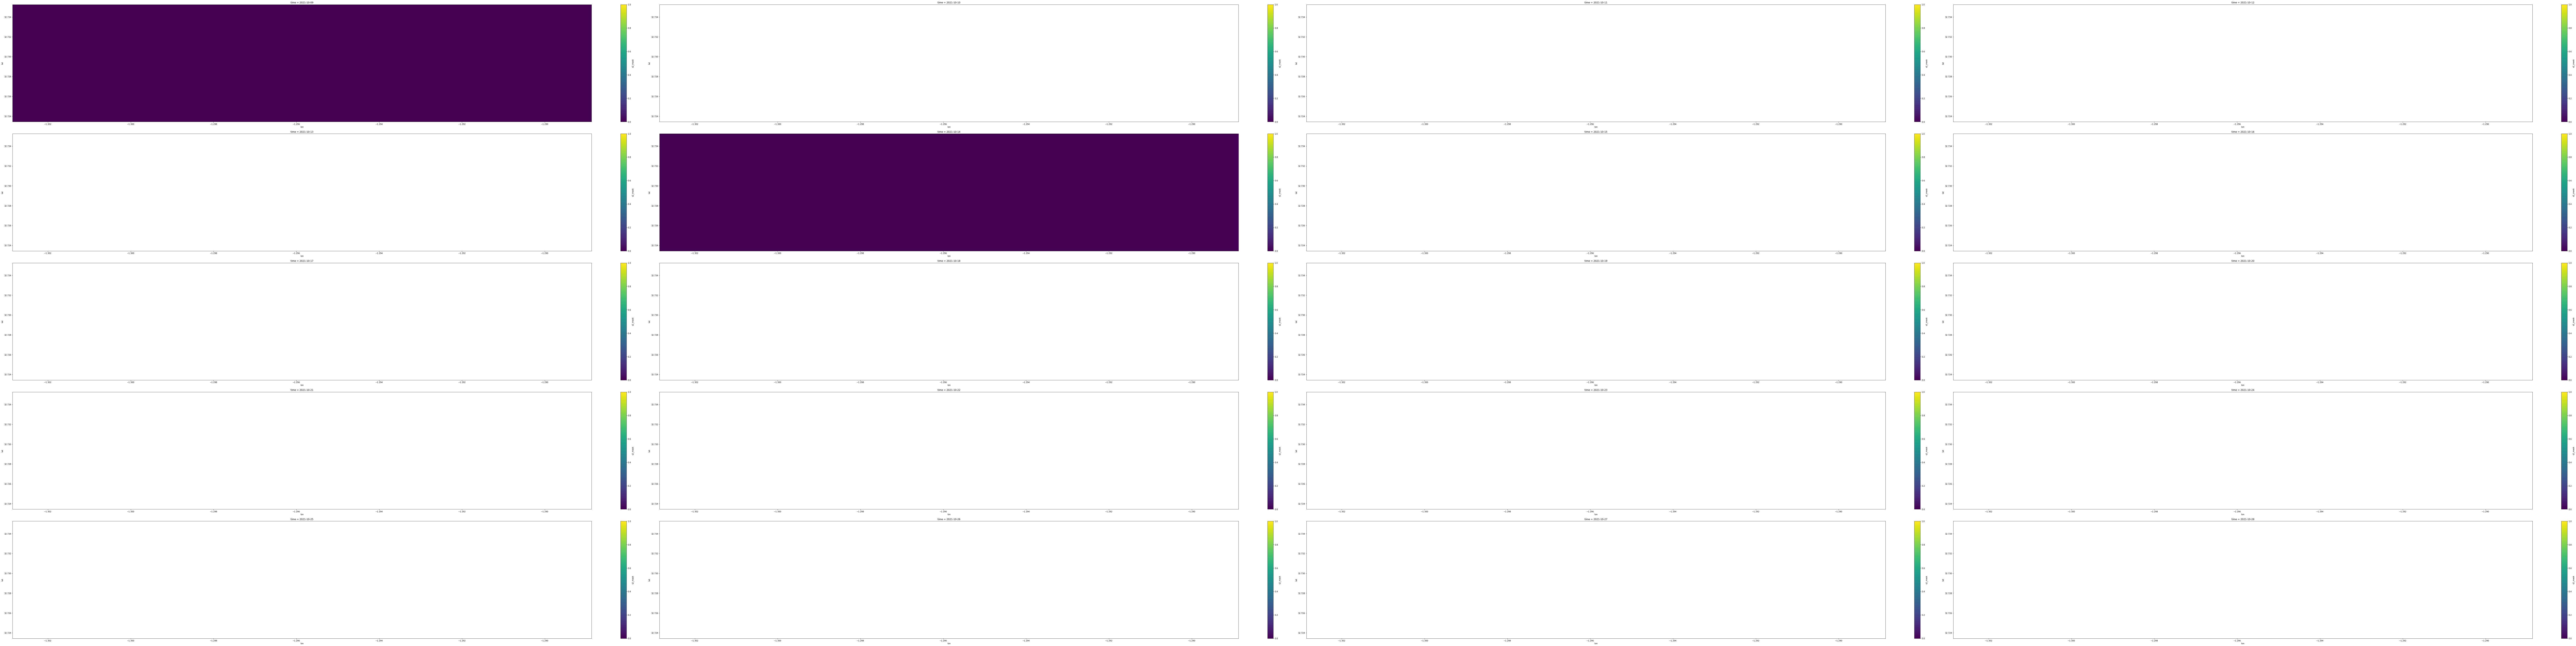

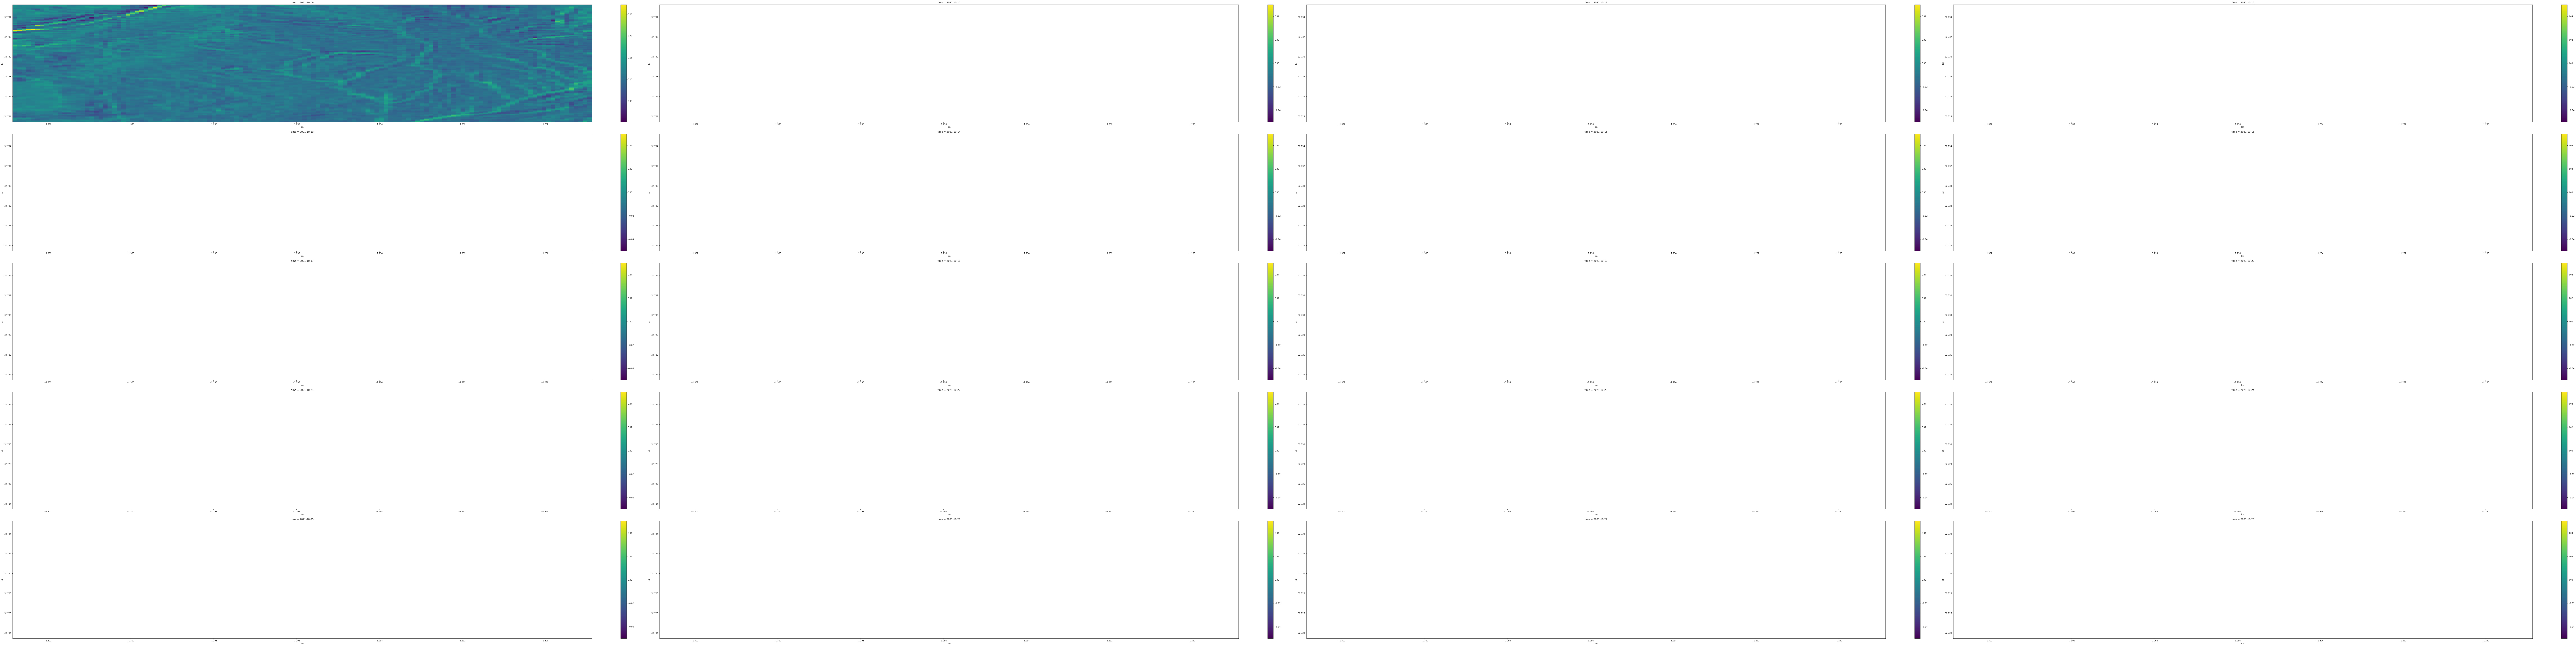

In [24]:
import matplotlib.pyplot as plt
import matplotlib.colors as clr
cmap_veg = clr.LinearSegmentedColormap.from_list('veg', ['#ffffe5','#f7fcb9','#d9f0a3','#addd8e','#78c679','#41ab5d','#238443','#006837','#004529'])


fig, axes = plt.subplots(nrows=5, ncols=4, constrained_layout=True, figsize=(180, 45))
index_avail = np.where(minicube.s2_avail.values == 1)[0]

t= index_avail[-20]
for i in range(5):
    for j in range(4):
        minicube.s2_mask.isel(time=t).plot(ax=axes[i,j], vmin=0, vmax=1)
        t += 1 # non gap filled, a lot of nan values

plt.draw()
print(minicube.s2_mask.isel(time=4).values)
print(minicube.s2_mask.isel(time=9).values)

fig, axes = plt.subplots(nrows=5, ncols=4, constrained_layout=True, figsize=(180, 45))
targ = (minicube.s2_B8A - minicube.s2_B04) / (minicube.s2_B8A + minicube.s2_B04 + 1e-6)
t= index_avail[-20]
for i in range(5):
    for j in range(4):
        targ.isel(time=t).plot(ax=axes[i,j])
        t += 5 # non gap filled, a lot of nan values

plt.draw()

In [13]:
s2_avail = minicube.s2_avail
print(type(s2_avail), s2_avail.shape)
index_avail = np.where(s2_avail == 1)[0]
print(index_avail)
print(index_avail[1:] - index_avail[:-1] - 5)
A = index_avail[1:] - index_avail[:-1] - 5
C = index_avail + A
print(np.where(A > 0)[0])

<class 'xarray.core.dataarray.DataArray'> (450,)
[  4   9  14  19  24  29  34  39  44  49  54  59  64  69  74  79  84  89
  94  99 104 109 114 119 124 129 134 139 144 149 154 159 164 169 174 179
 184 189 194 199 204 209 214 219 224 229 234 239 244 249 254 259 264 269
 274 279 284 289 294 299 304 309 314 319 324 329 334 339 344 349 354 359
 364 369 374 379 384 389 394 399 404 409 414 419 424 429 434 439 444 449]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


ValueError: operands could not be broadcast together with shapes (90,) (89,) 

In [19]:
print(index_avail[-20:])

[324 329 359 364 369 374 379 384 394 399 404 409 414 419 424 429 434 439
 444 449]


In [6]:
s2_avail = minicube.s2_avail
time = np.array([i for i in range(4, len(s2_avail), 5)])


# Select the days with available data
time = np.array([i for i in range(4, len(s2_avail), 5)])
print(s2_avail)
s2_avail = s2_avail.isel(time=time)
print(s2_avail)

<xarray.DataArray 's2_avail' (time: 450)>
[450 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2019-01-16 2019-01-17 ... 2020-04-09
Attributes:
    coordinates:  sentinel:product_id
<xarray.DataArray 's2_avail' (time: 90)>
[90 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2019-01-20 2019-01-25 ... 2020-04-09
Attributes:
    coordinates:  sentinel:product_id


In [21]:
        # Detect the missing day
        # Index of the availables days
        index_avail = np.where(s2_avail == 1)[0]
        missing = index_avail[1:] - index_avail[:-1] - 5
        # index of the missing days (due to cloud or other)
        index_missing = np.where(missing > 0)[0]
        if index_avail[0] % 5 != 4:
            raise Exception("bad assumption on the data, first value s2 =" + str(index_avail[0]))

4


In [20]:
time = [i for i in range(4, 450, 5)]
targs = minicube.s2_mask.isel(time=time).values[None,...].transpose((1,0,2,3)).astype(np.float16)
#avail = minicube.s2_avail.astype(bool).squeeze(0).unsqueeze(2).unsqueeze(3).unsqueeze(4).repeat(1, 1, targs.shape[2],targs.shape[3],targs.shape[3])
#targs = torch.where(avail, targs, avail)
nan = np.sum(np.isnan(targs))
print(nan)

786433


In [24]:
minicube.esawc_lc

<xarray.DataArray 'esawc_lc' (lat: 128, lon: 128)>
[16384 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 17.48 17.48 17.48 17.48 ... 17.49 17.49 17.49 17.49
  * lat      (lat) float64 -10.36 -10.36 -10.36 -10.36 ... -10.37 -10.37 -10.37
Attributes:
    provider:            ESA Worldcover
    interpolation_type:  nearest
    description:         Land cover classification
    classes:             \n                10 - Tree cover\n                2...
    coordinates:         sentinel:product_id